In [1]:
# Imports
import pandas as pd
import datetime as dt

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
atg_obs = pd.read_csv('../../Downloads/LFEM_data--3.csv', low_memory=False, skiprows=1)
atg_obs.insert(0, 'datetime_UTC', pd.to_datetime(atg_obs['Date'] + atg_obs['Time'], format='%Y-%m-%d%H:%M'))
# atg_obs_selected = atg_obs.loc[(atg_obs['datetime_UTC']>=dt.datetime(2020,5,1))].copy() # Selecting dates

In [50]:
atg_obs_selected = atg_obs.copy() # Selecting dates

In [51]:
atg_obs_selected = atg_obs_selected.loc[(atg_obs['datetime_UTC']>=dt.datetime(2014,5,1))]

In [52]:
atg_obs_selected

,datetime_UTC,Pseudo-Julian-Date,Date,Time,Temperature,Dewpoint,Relhum,Speed,Gust,Direction,Pressure,Solar,SumRain,Rain
7677284,2014-05-01 00:00:00,2.456779e+06,2014-05-01,00:00,81.700000,37.900000,20.9,8.200000,9.500000,314,1019.0,411.5,554.29,0.00
7677285,2014-05-01 00:01:00,2.456779e+06,2014-05-01,00:01,81.500000,38.000000,21.1,9.300000,10.800000,321,1019.0,408.6,554.29,0.00
7677286,2014-05-01 00:02:00,2.456779e+06,2014-05-01,00:02,81.200000,37.500000,21.0,8.100000,11.300000,307,1019.0,405.1,554.29,0.00
7677287,2014-05-01 00:03:00,2.456779e+06,2014-05-01,00:03,81.000000,36.300000,20.1,8.700000,9.700000,304,1018.9,401.7,554.29,0.00
7677288,2014-05-01 00:04:00,2.456779e+06,2014-05-01,00:04,80.900000,37.300000,21.0,6.800000,8.200000,294,1018.6,399.2,554.29,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12940427,2024-05-22 20:30:00,2.460454e+06,2024-05-22,20:30,55.900000,41.500000,58.5,6.100000,7.800000,267,1010.8,920.2,969.65,0.00
12940428,2024-05-22 20:31:00,2.460454e+06,2024-05-22,20:31,56.000000,41.700000,58.4,6.600000,9.500000,267,1010.9,756.5,969.65,0.00
12940429,2024-05-22 20:32:00,2.460454e+06,2024-05-22,20:32,56.200000,41.700000,58.2,5.900000,10.100000,357,1010.8,657.9,969.65,0.00
12940430,2024-05-22 20:33:00,2.460454e+06,2024-05-22,20:33,56.400000,42.100000,58.6,8.500000,10.500000,300,1011.0,570.1,969.65,0.00


In [53]:
no_erros_obs = atg_obs_selected.loc[(atg_obs_selected['Rain']!='M')&(atg_obs_selected['Temperature']!='M')&(atg_obs_selected['Pressure']!='M')&(atg_obs_selected['Relhum']!='M')&(atg_obs_selected['Relhum']!='0.00.')].copy()
no_erros_obs['Rain'] = no_erros_obs['Rain'].astype(float)
no_erros_obs['Temperature'] = no_erros_obs['Temperature'].astype(float)
no_erros_obs['Pressure'] = no_erros_obs['Pressure'].astype(float)
no_erros_obs['Relhum'] = no_erros_obs['Relhum'].astype(float)

In [54]:
no_erros_obs

,datetime_UTC,Pseudo-Julian-Date,Date,Time,Temperature,Dewpoint,Relhum,Speed,Gust,Direction,Pressure,Solar,SumRain,Rain
7677284,2014-05-01 00:00:00,2.456779e+06,2014-05-01,00:00,81.7,37.900000,20.9,8.200000,9.500000,314,1019.0,411.5,554.29,0.0
7677285,2014-05-01 00:01:00,2.456779e+06,2014-05-01,00:01,81.5,38.000000,21.1,9.300000,10.800000,321,1019.0,408.6,554.29,0.0
7677286,2014-05-01 00:02:00,2.456779e+06,2014-05-01,00:02,81.2,37.500000,21.0,8.100000,11.300000,307,1019.0,405.1,554.29,0.0
7677287,2014-05-01 00:03:00,2.456779e+06,2014-05-01,00:03,81.0,36.300000,20.1,8.700000,9.700000,304,1018.9,401.7,554.29,0.0
7677288,2014-05-01 00:04:00,2.456779e+06,2014-05-01,00:04,80.9,37.300000,21.0,6.800000,8.200000,294,1018.6,399.2,554.29,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12940427,2024-05-22 20:30:00,2.460454e+06,2024-05-22,20:30,55.9,41.500000,58.5,6.100000,7.800000,267,1010.8,920.2,969.65,0.0
12940428,2024-05-22 20:31:00,2.460454e+06,2024-05-22,20:31,56.0,41.700000,58.4,6.600000,9.500000,267,1010.9,756.5,969.65,0.0
12940429,2024-05-22 20:32:00,2.460454e+06,2024-05-22,20:32,56.2,41.700000,58.2,5.900000,10.100000,357,1010.8,657.9,969.65,0.0
12940430,2024-05-22 20:33:00,2.460454e+06,2024-05-22,20:33,56.4,42.100000,58.6,8.500000,10.500000,300,1011.0,570.1,969.65,0.0


In [55]:
first_obs_each_period = no_erros_obs.resample(on='datetime_UTC', rule='1h')
first_obs_each_period

In [56]:
summed_rain_each_period = first_obs_each_period['Rain'].sum()

lightrainfall_times = summed_rain_each_period[(summed_rain_each_period<=0.10)&(summed_rain_each_period>0.0)]
moderaterainfall_times = summed_rain_each_period[(summed_rain_each_period<0.30)&(summed_rain_each_period>0.10)]
heavyrainfall_times = summed_rain_each_period[(summed_rain_each_period>=0.30)]

any_rainfall_times = summed_rain_each_period[(summed_rain_each_period>0.0)]

summed_rain_each_period.loc[lightrainfall_times.index] = 1
summed_rain_each_period.loc[moderaterainfall_times.index] = 2
summed_rain_each_period.loc[heavyrainfall_times.index] = 3
# summed_rain_each_period.loc[any_rainfall_times.index] = 1

In [57]:
# Extract Date, Time, Temperature, SumRain into data array
atg_obs_necessary = pd.DataFrame()
atg_obs_necessary['date'] = first_obs_each_period['Date'].first()
atg_obs_necessary['time'] = first_obs_each_period['Time'].first()
atg_obs_necessary['temperature'] = first_obs_each_period['Temperature'].first()
atg_obs_necessary['pressure'] = first_obs_each_period['Pressure'].first()
atg_obs_necessary['relhum'] = first_obs_each_period['Relhum'].first()
atg_obs_necessary['rainfall_type'] = summed_rain_each_period

data_arr = atg_obs_necessary.values
atg_obs_necessary

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2014-05-01 00:00:00,2014-05-01,00:00,81.7,1019.0,20.9,0.0
2014-05-01 01:00:00,2014-05-01,01:00,80.6,1018.4,24.5,0.0
2014-05-01 02:00:00,2014-05-01,02:00,76.9,1017.6,28.6,0.0
2014-05-01 03:00:00,2014-05-01,03:00,74.4,1017.7,29.8,0.0
2014-05-01 04:00:00,2014-05-01,04:00,70.3,1017.7,34.8,0.0
...,...,...,...,...,...,...
2024-05-22 16:00:00,2024-05-22,16:00,49.9,1008.8,84.8,0.0
2024-05-22 17:00:00,2024-05-22,17:00,51.0,1009.1,74.8,0.0
2024-05-22 18:00:00,2024-05-22,18:00,54.2,1009.6,63.6,0.0


In [58]:
atg_obs_necessary.loc[atg_obs_necessary['rainfall_type']==2]

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2014-05-04 00:00:00,2014-05-04,00:00,51.4,1005.8,80.8,2.0
2014-05-04 01:00:00,2014-05-04,01:00,50.4,1005.5,86.6,2.0
2014-05-04 02:00:00,2014-05-04,02:00,51.0,1004.8,83.8,2.0
2014-05-04 04:00:00,2014-05-04,04:00,51.0,1003.8,89.3,2.0
2014-05-04 06:00:00,2014-05-04,06:00,50.7,1003.2,90.7,2.0
...,...,...,...,...,...,...
2024-04-30 01:00:00,2024-04-30,01:00,47.9,1014.4,76.0,2.0
2024-05-07 07:00:00,2024-05-07,07:00,46.0,1013.1,91.5,2.0
2024-05-19 11:00:00,2024-05-19,11:00,48.6,1017.7,88.1,2.0


In [59]:
atg_obs_train = atg_obs_necessary.loc[pd.to_datetime(atg_obs_necessary['date'], format='%Y-%m-%d')<dt.datetime(2020,5,1)]
atg_obs_train

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2014-05-01 00:00:00,2014-05-01,00:00,81.7,1019.0,20.9,0.0
2014-05-01 01:00:00,2014-05-01,01:00,80.6,1018.4,24.5,0.0
2014-05-01 02:00:00,2014-05-01,02:00,76.9,1017.6,28.6,0.0
2014-05-01 03:00:00,2014-05-01,03:00,74.4,1017.7,29.8,0.0
2014-05-01 04:00:00,2014-05-01,04:00,70.3,1017.7,34.8,0.0
...,...,...,...,...,...,...
2020-04-30 19:00:00,2020-04-30,19:00,55.3,1015.0,52.4,0.0
2020-04-30 20:00:00,2020-04-30,20:00,56.1,1015.1,51.6,0.0
2020-04-30 21:00:00,2020-04-30,21:00,56.2,1015.2,56.2,0.0


In [60]:
notable_event_times = atg_obs_train.loc[atg_obs_train['rainfall_type']>=2].index

relevant_times_train = pd.DataFrame()
for event_time in notable_event_times:
    # event_time = notable_event_times[1]
    if not(event_time in relevant_times_train.index):
        time_around_event = atg_obs_train.loc[event_time-pd.Timedelta(days=15):event_time+pd.Timedelta(days=15)].copy()
        relevant_times_train = pd.concat([relevant_times_train, time_around_event])
relevant_times_train

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2014-05-01 00:00:00,2014-05-01,00:00,81.7,1019.0,20.9,0.0
2014-05-01 01:00:00,2014-05-01,01:00,80.6,1018.4,24.5,0.0
2014-05-01 02:00:00,2014-05-01,02:00,76.9,1017.6,28.6,0.0
2014-05-01 03:00:00,2014-05-01,03:00,74.4,1017.7,29.8,0.0
2014-05-01 04:00:00,2014-05-01,04:00,70.3,1017.7,34.8,0.0
...,...,...,...,...,...,...
2020-04-30 19:00:00,2020-04-30,19:00,55.3,1015.0,52.4,0.0
2020-04-30 20:00:00,2020-04-30,20:00,56.1,1015.1,51.6,0.0
2020-04-30 21:00:00,2020-04-30,21:00,56.2,1015.2,56.2,0.0


In [61]:
atg_obs_val = atg_obs_necessary.loc[(pd.to_datetime(atg_obs_necessary['date'], format='%Y-%m-%d')>=dt.datetime(2020,5,1))&(pd.to_datetime(atg_obs_necessary['date'], format='%Y-%m-%d')<dt.datetime(2022,5,1))]
atg_obs_val

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2020-05-01 00:00:00,2020-05-01,00:00,55.6,1015.2,57.7,0.0
2020-05-01 01:00:00,2020-05-01,01:00,55.8,1015.4,53.3,0.0
2020-05-01 02:00:00,2020-05-01,02:00,54.1,1015.6,56.9,0.0
2020-05-01 03:00:00,2020-05-01,03:00,53.5,1015.8,61.1,0.0
2020-05-01 04:00:00,2020-05-01,04:00,52.1,1016.5,65.7,0.0
...,...,...,...,...,...,...
2022-04-30 19:00:00,2022-04-30,19:00,54.2,1010.9,72.4,0.0
2022-04-30 20:00:00,2022-04-30,20:00,55.9,1010.8,62.2,0.0
2022-04-30 21:00:00,2022-04-30,21:00,57.9,1010.5,55.7,1.0


In [62]:
notable_event_times = atg_obs_val.loc[atg_obs_val['rainfall_type']>=2].index

relevant_times_val = pd.DataFrame()
for event_time in notable_event_times:
    # event_time = notable_event_times[1]
    if not(event_time in relevant_times_val.index):
        time_around_event = atg_obs_val.loc[event_time-pd.Timedelta(days=15):event_time+pd.Timedelta(days=15)].copy()
        relevant_times_val = pd.concat([relevant_times_val, time_around_event])
relevant_times_val

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2020-05-02 05:00:00,2020-05-02,05:00,58.1,1011.6,48.3,0.0
2020-05-02 06:00:00,2020-05-02,06:00,58.2,1011.3,46.1,0.0
2020-05-02 07:00:00,2020-05-02,07:00,56.5,1010.7,49.9,0.0
2020-05-02 08:00:00,2020-05-02,08:00,56.5,1010.2,54.2,0.0
2020-05-02 09:00:00,2020-05-02,09:00,55.1,1009.3,58.8,0.0
...,...,...,...,...,...,...
2022-04-30 19:00:00,2022-04-30,19:00,54.2,1010.9,72.4,0.0
2022-04-30 20:00:00,2022-04-30,20:00,55.9,1010.8,62.2,0.0
2022-04-30 21:00:00,2022-04-30,21:00,57.9,1010.5,55.7,1.0


In [63]:
atg_obs_test = atg_obs_necessary.loc[pd.to_datetime(atg_obs_necessary['date'], format='%Y-%m-%d')>=dt.datetime(2022,5,1)]
atg_obs_test

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2022-05-01 00:00:00,2022-05-01,00:00,60.7,1011.5,43.0,0.0
2022-05-01 01:00:00,2022-05-01,01:00,59.6,1012.1,51.4,0.0
2022-05-01 02:00:00,2022-05-01,02:00,58.1,1012.8,53.9,0.0
2022-05-01 03:00:00,2022-05-01,03:00,54.5,1013.4,62.5,0.0
2022-05-01 04:00:00,2022-05-01,04:00,53.3,1014.1,65.4,0.0
...,...,...,...,...,...,...
2024-05-22 16:00:00,2024-05-22,16:00,49.9,1008.8,84.8,0.0
2024-05-22 17:00:00,2024-05-22,17:00,51.0,1009.1,74.8,0.0
2024-05-22 18:00:00,2024-05-22,18:00,54.2,1009.6,63.6,0.0


In [64]:
notable_event_times = atg_obs_test.loc[atg_obs_test['rainfall_type']>=2].index

relevant_times_test = pd.DataFrame()
for event_time in notable_event_times:
    if not(event_time in relevant_times_test.index):
        time_around_event = atg_obs_test.loc[event_time-pd.Timedelta(days=15):event_time+pd.Timedelta(days=15)].copy()
        relevant_times_test = pd.concat([relevant_times_test, time_around_event])
relevant_times_test

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2022-05-01 00:00:00,2022-05-01,00:00,60.7,1011.5,43.0,0.0
2022-05-01 01:00:00,2022-05-01,01:00,59.6,1012.1,51.4,0.0
2022-05-01 02:00:00,2022-05-01,02:00,58.1,1012.8,53.9,0.0
2022-05-01 03:00:00,2022-05-01,03:00,54.5,1013.4,62.5,0.0
2022-05-01 04:00:00,2022-05-01,04:00,53.3,1014.1,65.4,0.0
...,...,...,...,...,...,...
2024-05-22 16:00:00,2024-05-22,16:00,49.9,1008.8,84.8,0.0
2024-05-22 17:00:00,2024-05-22,17:00,51.0,1009.1,74.8,0.0
2024-05-22 18:00:00,2024-05-22,18:00,54.2,1009.6,63.6,0.0


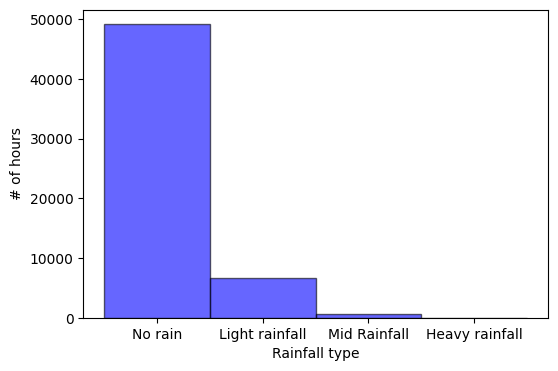

(array([49121,  6622,   620,    24]), array([0, 1, 2, 3, 4]))

In [65]:
rain_counts, classes = np.histogram(relevant_times_train['rainfall_type'].values, bins=np.arange(0,5))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,4), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,4), labels=['No rain', 'Light rainfall', 'Mid Rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

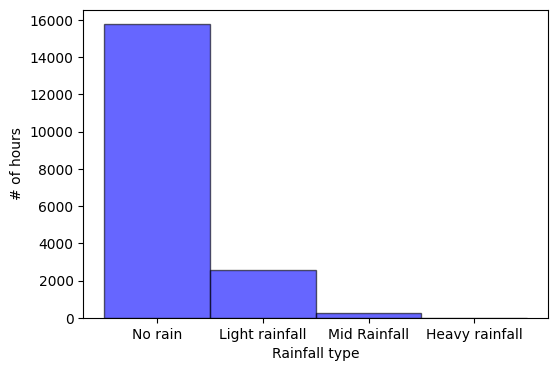

(array([15763,  2539,   271,     8]), array([0, 1, 2, 3, 4]))

In [66]:
rain_counts, classes = np.histogram(relevant_times_val['rainfall_type'].values, bins=np.arange(0,5))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,4), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,4), labels=['No rain', 'Light rainfall', 'Mid Rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

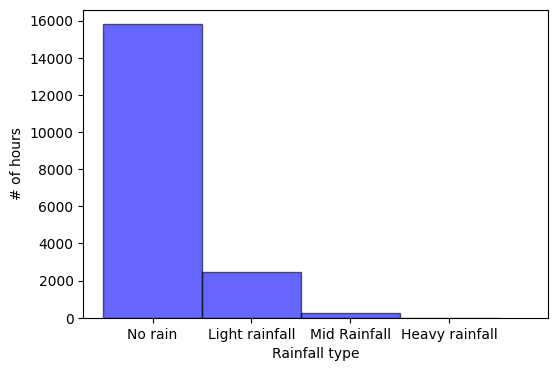

(array([15797,  2473,   257,    10]), array([0, 1, 2, 3, 4]))

In [67]:
rain_counts, classes = np.histogram(relevant_times_test['rainfall_type'].values, bins=np.arange(0,5))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,4), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(np.arange(0,5))
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,4), labels=['No rain', 'Light rainfall', 'Mid Rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

In [68]:
relevant_times_train.shape[0], relevant_times_val.shape[0], relevant_times_test.shape[0]

(56387, 18581, 18537)

In [69]:
train_split = 100*(relevant_times_train.shape[0] / (relevant_times_val.shape[0]+relevant_times_train.shape[0]+relevant_times_test.shape[0]))
val_split = 100*(relevant_times_val.shape[0] / (relevant_times_val.shape[0]+relevant_times_train.shape[0]+relevant_times_test.shape[0]))
test_split = 100*(relevant_times_test.shape[0] / (relevant_times_val.shape[0]+relevant_times_train.shape[0]+relevant_times_test.shape[0]))
train_split, val_split, test_split

(60.303727073418536, 19.87166461686541, 19.82460830971606)

In [70]:
def get_processed_df_from_data(dataset):
    date_objs = pd.to_datetime(dataset['date'], format="%Y-%m-%d")
    time_objs = pd.to_datetime(dataset['time'], format='%H:%M')

    days_of_year = pd.DatetimeIndex(date_objs).dayofyear
    months = pd.DatetimeIndex(date_objs).month
    times_in_hours_from_zero = (pd.DatetimeIndex(time_objs).hour + (pd.DatetimeIndex(time_objs).minute/60))

    processed_df = pd.DataFrame()
    processed_df['months_from_july'] = (np.abs(months - 7))
    # processed_df['days_of_year'] = days_of_year
    # processed_df['times_in_hours_from_zero'] = times_in_hours_from_zero

    vals = dataset['temperature']
    med_val = vals.median()
    dif_vals = np.abs(vals-med_val)
    max_normval = dif_vals.max()
    norm_vals = 1-(dif_vals/max_normval)
    processed_df['feature_1'] = norm_vals.values

    vals = dataset['relhum']
    med_val = vals.median()
    dif_vals = np.abs(vals-med_val)
    max_normval = dif_vals.max()
    norm_vals = 1-(dif_vals/max_normval)
    processed_df['feature_2'] = norm_vals.values

    vals = dataset['pressure']
    med_val = vals.median()
    dif_vals = np.abs(vals-med_val)
    max_normval = dif_vals.max()
    norm_vals = 1-(dif_vals/max_normval)
    processed_df['feature_3'] = norm_vals.values

    processed_df['class'] = dataset['rainfall_type'].values
    return processed_df

In [71]:
processed_df_train = get_processed_df_from_data(relevant_times_train)
processed_df_val = get_processed_df_from_data(relevant_times_val)
processed_df_test = get_processed_df_from_data(relevant_times_test)

In [72]:
processed_df_train.loc[processed_df_train['class']==1]

,months_from_july,feature_1,feature_2,feature_3,class
68,2,0.890625,0.785137,0.781250,1.0
69,2,0.947266,0.975767,0.787500,1.0
70,2,0.935547,0.977383,0.781250,1.0
71,2,0.996094,0.864297,0.784375,1.0
75,2,0.996094,0.735057,0.718750,1.0
...,...,...,...,...,...
56297,3,0.974609,0.928918,0.900000,1.0
56298,3,0.957031,0.819063,0.884375,1.0
56299,3,0.958984,0.752827,0.868750,1.0
56300,3,0.972656,0.735057,0.856250,1.0


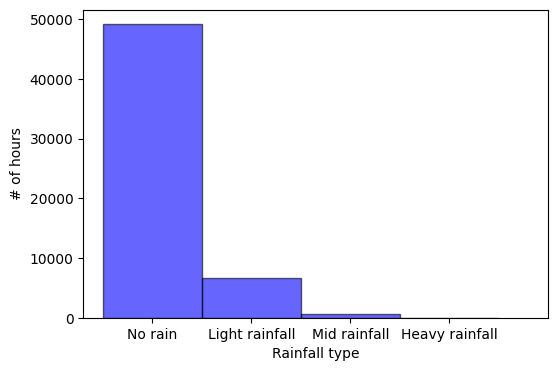

(array([49121,  6622,   620,    24]), array([0, 1, 2, 3, 4]))

In [73]:
rain_counts, classes = np.histogram(processed_df_train['class'].values, bins=np.arange(0,5))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,4), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(np.arange(0,5))
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,4), labels=['No rain', 'Light rainfall', 'Mid rainfall',  'Heavy rainfall'])
plt.xlabel('Rainfall type')
# plt.yscale('log')
plt.show()
rain_counts, classes

In [74]:
processed_data_train = processed_df_train.values.astype(float)
processed_data_val = processed_df_val.values.astype(float)
processed_data_train.shape

(56387, 5)

In [75]:
processed_data_val.shape

(18581, 5)

In [76]:
processed_data_test = processed_df_test.values.astype(float)

In [77]:
processed_data_test.shape

(18537, 5)

In [78]:
print(f'Data Shape: {data_arr.shape}')
print(f'Data Entry: [Month from July, Temperature, Relative Humidity, Pressure, Rain type]')

# Pre-Processed
print(data_arr[0])

# Post-Processed
print(processed_data_train[0])
print(processed_data_val[0])
print(processed_data_test[0])

Data Shape: (88197, 6)
Data Entry: [Month from July, Temperature, Relative Humidity, Pressure, Rain type]
['2014-05-01' '00:00' 81.7 1019.0 20.9 0.0]
[2.         0.40429688 0.16801292 0.821875   0.        ]
[2.         0.76368159 0.5751634  0.91388889 0.        ]
[2.         0.85344828 0.46451613 0.97927461 0.        ]


In [79]:
x_data_train = processed_data_train[:, :4]
y_data_train = processed_data_train[:, 4:].astype(int)
print(x_data_train[0], y_data_train[0])

[2.         0.40429688 0.16801292 0.821875  ] [0]


In [80]:
x_data_val = processed_data_val[:, :4]
y_data_val = processed_data_val[:, 4:].astype(int)
print(x_data_val[0], y_data_val[0])

[2.         0.76368159 0.5751634  0.91388889] [0]


In [81]:
x_data_test = processed_data_test[:, :4]
y_data_test = processed_data_test[:, 4:].astype(int)
print(x_data_test[0], y_data_test[0])

[2.         0.85344828 0.46451613 0.97927461] [0]


In [82]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler

In [83]:
x_data_test.shape

(18537, 4)

In [84]:
y_data_test.shape

(18537, 1)

In [85]:
from imblearn.over_sampling import SMOTE 
smote = SMOTE(random_state = 42) 
x_train_res, y_train_res = smote.fit_resample(x_data_train, y_data_train.ravel()) 
x_val_res, y_val_res = smote.fit_resample(x_data_val, y_data_val.ravel())

In [86]:
x_data_test.shape

(18537, 4)

In [87]:
x_test_res, y_test_res = smote.fit_resample(x_data_test, y_data_test.ravel()) 

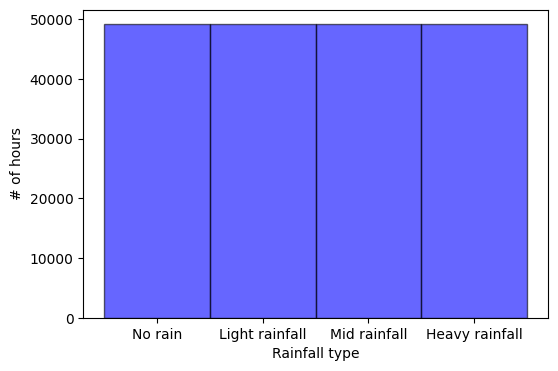

(array([49121, 49121, 49121, 49121]), array([0, 1, 2, 3, 4]))

In [88]:
rain_counts, classes = np.histogram(y_train_res, bins=np.arange(0,5))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,4), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
# plt.xticks(np.arange(0,4))
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,4), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [89]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train_res)
X_val_scaled = scaler.transform(x_val_res)
X_test_scaled = scaler.transform(x_test_res)

# Define the model
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(4,)))

# Hidden layers
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(4, activation='softmax'))  # Softmax for multiclass classification

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Print model summary
model.summary()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"


2024-05-22 13:46:54.710656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-22 13:46:54.711407: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 2,532
Trainable params: 2,532
Non-trainable params: 0
_________________________________________________________________


In [90]:
X_train_scaled.shape, y_train_res.shape

((196484, 4), (196484,))

In [91]:
X_val_scaled.shape, y_val_res.shape

((63052, 4), (63052,))

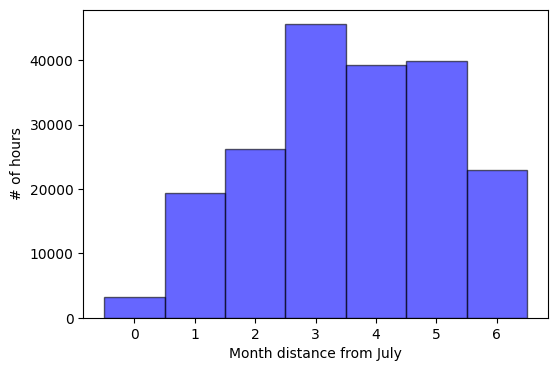

(array([ 3231, 19352, 26218, 45595, 39342, 39834, 22912]),
 array([0, 1, 2, 3, 4, 5, 6, 7]))

In [92]:
binwidth = 1
rain_counts, classes = np.histogram(x_train_res[:,0], bins=np.arange(0,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(0,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
# plt.xticks(np.arange(-1,1+binwidth,binwidth))
plt.ylabel('# of hours')
# plt.xticks(ticks=np.arange(0,4), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Month distance from July')
plt.show()
rain_counts, classes

In [93]:
X_train_scaled

array([[-1.03251365, -3.00990908, -5.65852171,  0.26224211],
       [-1.03251365, -2.86709991, -5.14540099,  0.37031425],
       [-1.03251365, -2.38674179, -4.56101349,  0.51441044],
       ...,
       [ 1.53772778,  0.75505994,  0.76974073,  1.12681924],
       [ 0.25260707,  0.20357319, -0.79750462, -0.35102153],
       [-1.03251365, -0.09491231, -0.27706418,  0.49748457]])

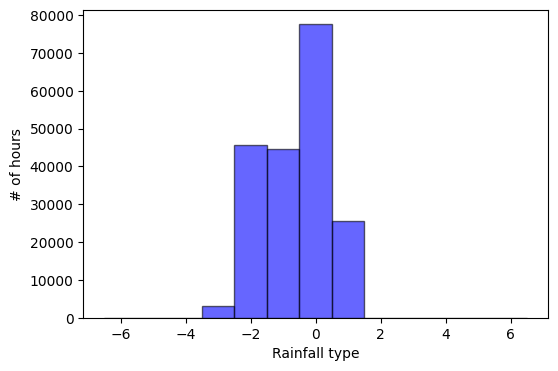

(array([    0,     0,     0,  3231, 45570, 44499, 77546, 25638,     0,
            0,     0,     0,     0]),
 array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7]))

In [94]:
binwidth = 1
rain_counts, classes = np.histogram(X_train_scaled[:,0], bins=np.arange(-6,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
# plt.title(f'Hours where it rained at least {rain_thresh} inches')
plt.bar(x=np.arange(-6,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
# plt.xticks(np.arange(-1,1+binwidth,binwidth))
plt.ylabel('# of hours')
# plt.xticks(ticks=np.arange(0,4), labels=['No rain', 'Light rainfall', 'Mid rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [95]:
# Train the Model:
history = model.fit(
    X_train_scaled, y_train_res,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_scaled, y_val_res),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10


2024-05-22 13:47:02.541306: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-05-22 13:47:02.812058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6141/6141 [==============================] - ETA: 0s - loss: 1.0317 - accuracy: 0.5534

2024-05-22 13:47:47.944158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6141/6141 [==============================] - 53s 8ms/step - loss: 1.0317 - accuracy: 0.5534 - val_loss: 5.9208 - val_accuracy: 0.3654 - lr: 0.0010
Epoch 2/10
6141/6141 [==============================] - 52s 8ms/step - loss: 0.9108 - accuracy: 0.6072 - val_loss: 7.9711 - val_accuracy: 0.3714 - lr: 0.0010
Epoch 3/10
6141/6141 [==============================] - 51s 8ms/step - loss: 0.8864 - accuracy: 0.6155 - val_loss: 8.9355 - val_accuracy: 0.3684 - lr: 0.0010
Epoch 4/10
6141/6141 [==============================] - 51s 8ms/step - loss: 0.8748 - accuracy: 0.6201 - val_loss: 9.7076 - val_accuracy: 0.3645 - lr: 0.0010
Epoch 5/10
6141/6141 [==============================] - 52s 8ms/step - loss: 0.8656 - accuracy: 0.6235 - val_loss: 10.1625 - val_accuracy: 0.3627 - lr: 0.0010
Epoch 6/10
6141/6141 [==============================] - 51s 8ms/step - loss: 0.8606 - accuracy: 0.6247 - val_loss: 10.4231 - val_accuracy: 0.3636 - lr: 0.0010
Epoch 7/10
6141/6141 [==============================] - 52s 8

In [96]:
# Evaluation (Is it worth, the loss is quite high suggesting that either the model architecture is quite poor (likely) or 
# that we need to better preprocess our data such as rain (also likely))

In [97]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [98]:
predictions = model.predict(X_test_scaled)

  23/1975 [..............................] - ETA: 10s

2024-05-22 13:55:44.156441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1975/1975 [==============================] - 4s 2ms/step


In [99]:
np.argmax(predictions[0])

0

In [100]:
y_test_res[0]

0

In [101]:
model.evaluate(X_test_scaled, y_test_res.astype(float), verbose=2)

2024-05-22 13:55:52.212606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1975/1975 - 8s - loss: 2.2230 - accuracy: 0.3983 - 8s/epoch - 4ms/step


[2.2230427265167236, 0.3983193039894104]

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [103]:
y_test_res

array([0, 0, 0, ..., 3, 3, 3])

In [104]:
np.argmax(predictions,axis=1)

array([0, 0, 0, ..., 0, 3, 2])

Confusion Matrix:
[[7399 4730 3031  637]
 [2743 4271 8098  685]
 [2006 3191 9863  737]
 [1932 1327 8902 3636]]


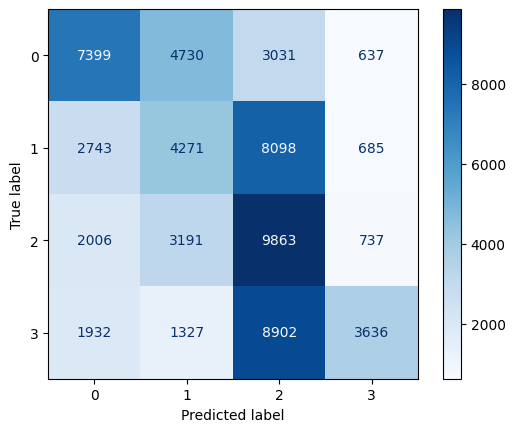

In [105]:
cm = confusion_matrix(y_test_res, np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [106]:
f1_score(y_test_res, np.argmax(predictions,axis=1), average=None)

array([0.49529739, 0.29137672, 0.43172616, 0.33835846])